# WRF / SCI Air Temperature Comparison
__Author__: Pat McCornack

__Date__: 

__Description__: 

__Notes__:
- The RH sensor seems to drift over time. The max value in 2007 is 100.32, and in 2008 it's 98.2, and in 2009 it's 96.45.

In [1]:
import os 
import glob 

import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from math import sqrt

from metpy.calc import wind_speed
from metpy.calc import wind_direction 
from metpy.units import units

import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D
import seaborn as sns

# Functions

In [2]:
def plot_var(wdf, odf, wvar, ovar, daterange, site):
    wdf = wdf[daterange[0] : daterange[1]]
    odf = odf[daterange[0] : daterange[1]]
    
    year = daterange[0].split('-')[0]
    month = daterange[0].split('-')[1]

    fig, ax = plt.subplots(figsize=(20,6))
    
    ax.plot(wdf.index, wdf[wvar], color='blue', label=f'WRF {wvar}')
    ax.plot(odf.index, odf[ovar], color='orange', label=f'Obs {wvar}')

    fig.legend(loc='upper right', bbox_to_anchor=(1.10, .99), bbox_transform=ax.transAxes)

    ax.set(title=f'Model vs. Observational {wvar}\n {site} {month}/{year}',
           ylabel=f'{ovar}')

    plt.show()
    
def plot_scatter(wdf, odf, wvar, ovar, site):
    join_df = wdf[[wvar]].join(odf[[ovar]],  how='inner')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x=join_df[ovar],
               y=join_df[wvar],
               alpha=0.25)
    
    ax.set(xlabel='Observed',
           ylabel='WRF',
           title=f'{site} {ovar}')
           
    plt.show()
    
def plot_scatter(wdf, odf, wvar, ovar, site):
    join_df = wdf[[wvar]].join(odf[[ovar]],  how='inner')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x=join_df[ovar],
               y=join_df[wvar],
               alpha=0.25)
    
    ax.set(xlabel='Observed',
           ylabel='WRF',
           title=f'{site} {ovar}')
           
    plt.show()
    
def plot_cdf(wdf, odf, wvar, ovar, site):
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.ecdfplot(data=wdf, x=wvar, ax=ax, color='blue', label='WRF')
    sns.ecdfplot(data=odf, x=ovar, ax=ax, color='orange', label='Observed')
    
    plt.legend(loc='upper left')
    ax.set(title=f'{site} CDF\n{ovar}')
    
def plot_kde(wdf, odf, wvar, ovar, site):
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.kdeplot(data=wdf, x=wvar, ax=ax, color='blue', label='WRF')
    sns.kdeplot(data=odf, x=ovar, ax=ax, color='orange', label='Observed')
    
    plt.legend(loc='upper left')
    ax.set(title=f'{site} PDF\n{ovar}')

#### Join and drop missing observations ####
def run_stats(wrf_df, obs_df, wrf_var, obs_var):
    join_df = wrf_df[[wrf_var]].join(obs_df[[obs_var]],  how='inner')
    join_df.columns = ['wRH', 'oRH']
    join_df = join_df.dropna()

    #### SAUC Stats ####
    xval = join_df['oRH']
    ymod = join_df['wRH']

    res = np.corrcoef(xval, ymod)
    corr_sauc = res[0,1]
    bias_sauc = (ymod - xval).mean()
    tmp = (ymod - xval)**2
    rmse_sauc = np.sqrt(tmp.mean())
    mabs_sauc = np.abs(ymod - xval).mean()

    print(f'Correlation: {round(corr_sauc, 2)}')
    print(f'Bias: {round(bias_sauc, 2)}')
    print(f'RMSE: {round(rmse_sauc, 2)}')
    print(f'MAE: {round(mabs_sauc, 2)}')
    print()
    
#### Calculate wind speed/direction from components ####
def get_wind(df): 
    u = df['U10'].values * units('m/s')
    v = df['V10'].values * units('m/s')

    df['WND_SPD'] = wind_speed(u,v)
    df['WND_DIR'] = wind_direction(u, v, convention='from')
    
    return df

# Read in and Prepare Data

In [3]:
#### Read in WRF data ####
wdatadir = '/home/patmccornack/data/wrf_extracted/interpolated_v2'
wsauc_fname = 'wrf_sauc_2003-2010.pkl'
wupem_fname = 'wrf_upem_2003-2010.pkl'
wnrs_sci_fname = 'wrf_nrs_sci_2014-2019.pkl'

wsauc = pd.read_pickle(os.path.join(wdatadir, wsauc_fname))
wupem = pd.read_pickle(os.path.join(wdatadir, wupem_fname))
wnrs_sci = pd.read_pickle(os.path.join(wdatadir, wnrs_sci_fname))

In [4]:
#### Convert Air Temp to C #####
wsauc['T2'] = wsauc['T2'] - 273
wupem['T2'] = wupem['T2'] - 273
wnrs_sci['T2'] = wnrs_sci['T2'] - 273

#### Convert UTC to PST ####
wsauc.index = wsauc.index - pd.Timedelta(hours=8)
wupem.index = wupem.index - pd.Timedelta(hours=8)
wnrs_sci.index = wnrs_sci.index - pd.Timedelta(hours=8)

In [5]:
#### Get wind speed/direction from components ####
wsauc = get_wind(wsauc)
wupem = get_wind(wupem)
wnrs_sci = get_wind(wnrs_sci)

In [6]:
#### Read in observational data #####
odatadir = '/home/patmccornack/data/preprocessed'
osauc_fname = 'SAUC_hourly.csv'
oupem_fname = 'UPEM_hourly.csv'
onrs_sci_fname = 'NRS_SCI_hourly.csv'

osauc = pd.read_csv(os.path.join(odatadir, osauc_fname), index_col='time (PST)')
oupem = pd.read_csv(os.path.join(odatadir, oupem_fname), index_col='time (PST)')
onrs_sci = pd.read_csv(os.path.join(odatadir, onrs_sci_fname), index_col='time (PST)')
osauc.index = pd.to_datetime(osauc.index)
oupem.index = pd.to_datetime(oupem.index)
onrs_sci.index = pd.to_datetime(onrs_sci.index)

# Relative Humidity

In [7]:
wvar = 'RH'
ovar = 'relative humidity (%)'

## Time Series Plots

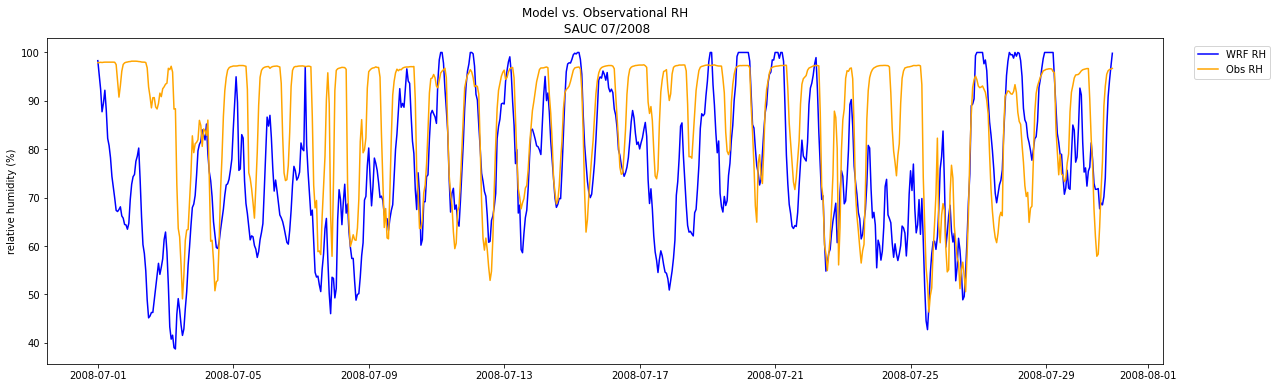

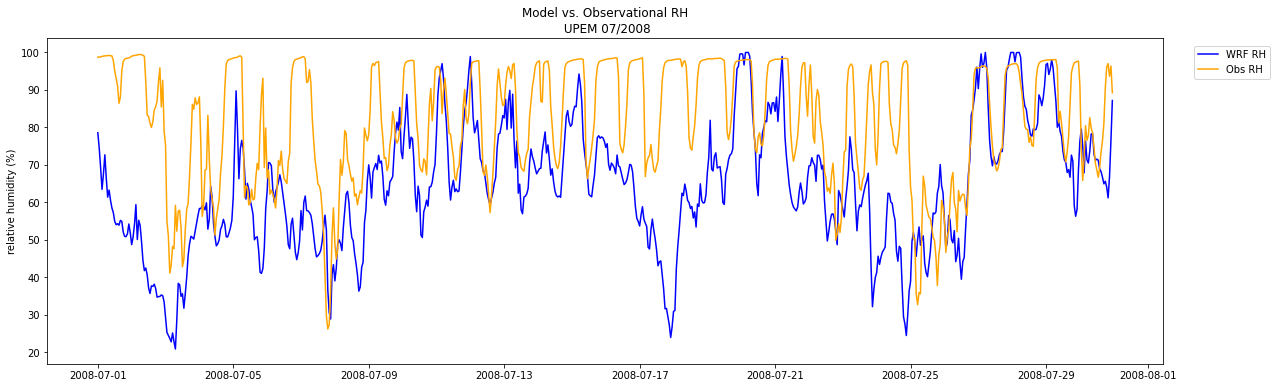

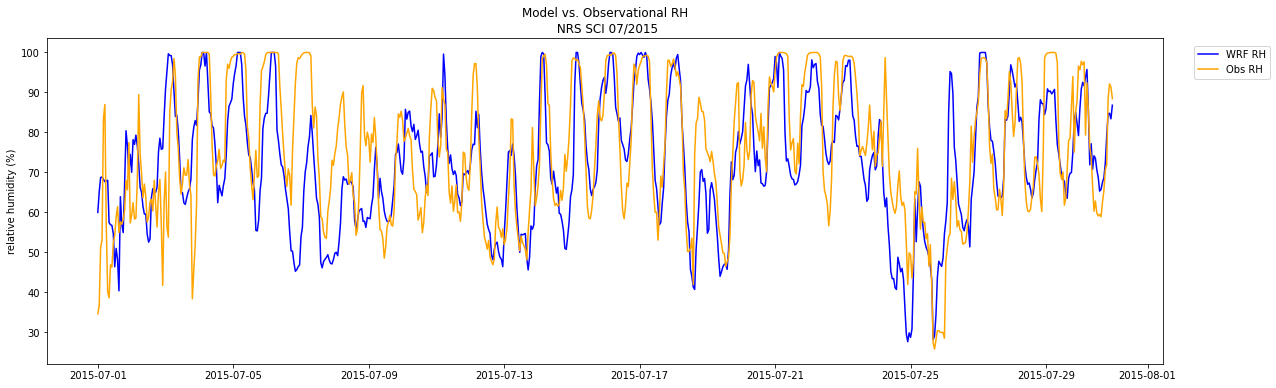

In [8]:
#### July RH ####
daterange = ['2008-07-01','2008-07-30']
nrs_daterange = ['2015-07-01', '2015-07-30']
plot_var(wsauc, osauc, wvar, ovar, daterange, 'SAUC')
plot_var(wupem, oupem, wvar, ovar, daterange, 'UPEM')
plot_var(wnrs_sci, onrs_sci, wvar, ovar, nrs_daterange, 'NRS SCI')

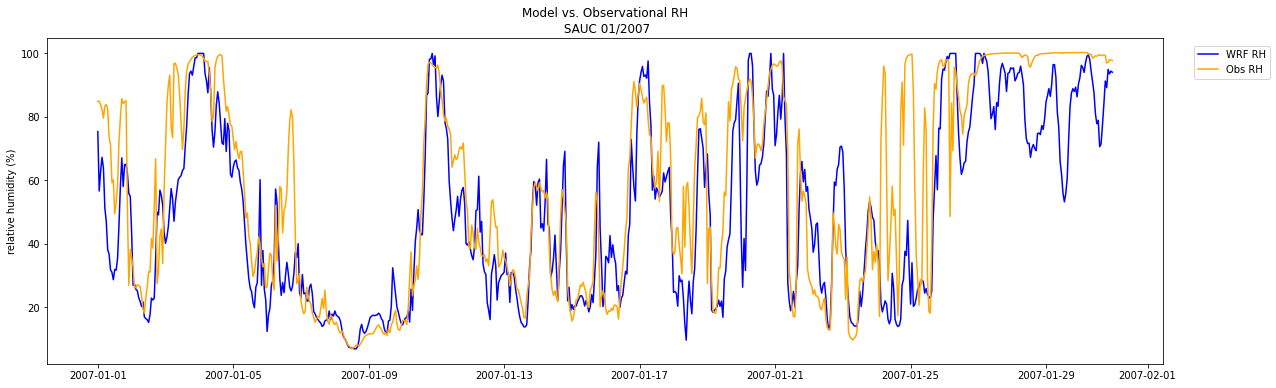

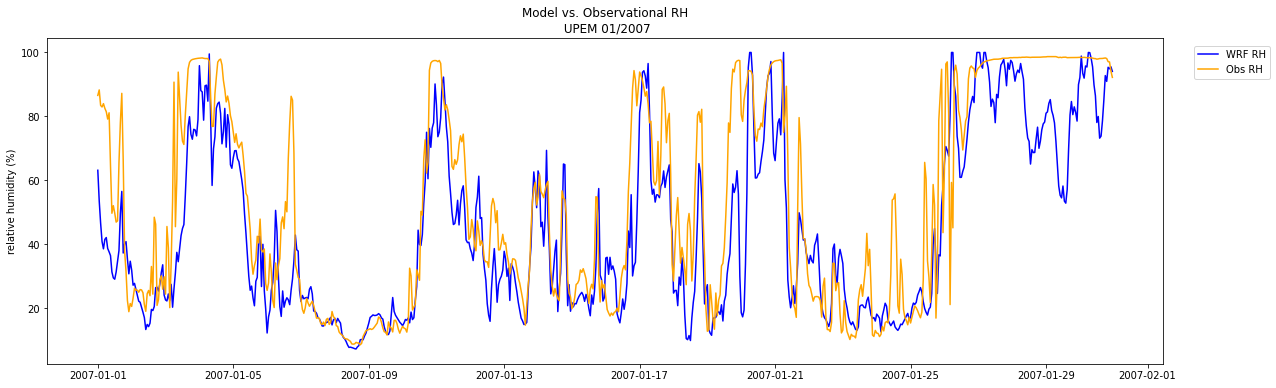

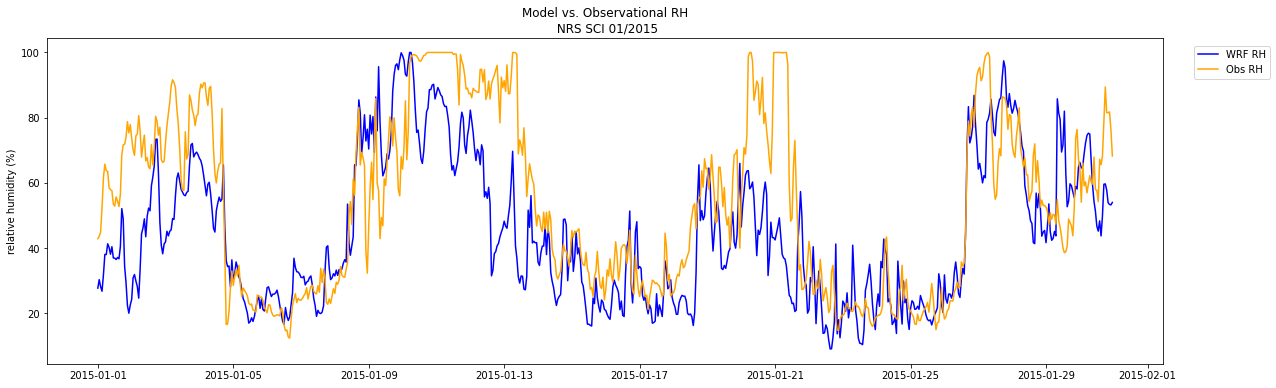

In [9]:
#### January RH ####
daterange = ['2007-01-01','2007-01-30']
nrs_daterange = ['2015-01-01', '2015-01-30']
plot_var(wsauc, osauc, wvar, ovar, daterange, 'SAUC')
plot_var(wupem, oupem, wvar, ovar, daterange, 'UPEM')
plot_var(wnrs_sci, onrs_sci, wvar, ovar, nrs_daterange, 'NRS SCI')

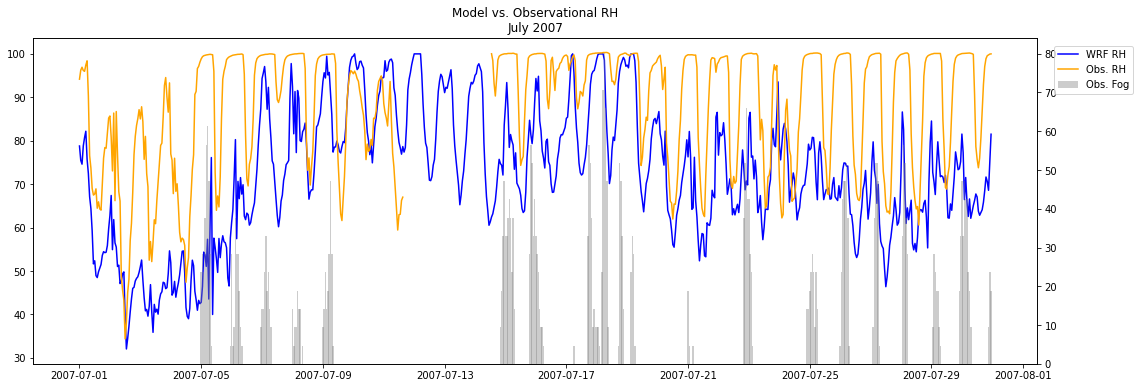

In [10]:
#### Does the misalignment come from fog? ####
fig, ax = plt.subplots(figsize=(18,6))
wdf = wsauc['2007-07-01':'2007-07-30']
odf = osauc['2007-07-01':'2007-07-30']

ax.plot(wdf.index, wdf['RH'], color='blue', label='WRF RH')
ax.plot(odf.index, odf['relative humidity (%)'], color='orange', label='Obs. RH')

ax2 = ax.twinx()
ax2.bar(odf.index, odf['fog drip'], color='grey', alpha=0.4, width=0.05, label='Obs. Fog')

fig.legend(loc='upper right', bbox_to_anchor=(1.10, .99), bbox_transform=ax.transAxes)

ax.set(title=f'Model vs. Observational RH\nJuly 2007')

plt.show()

## Scatter Plots

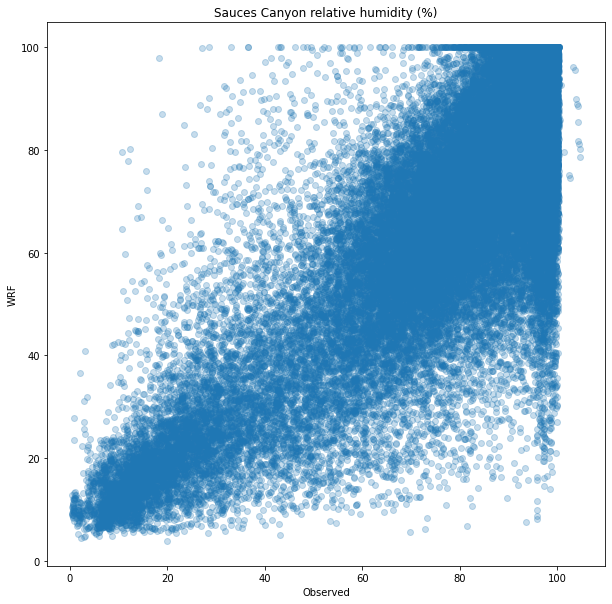

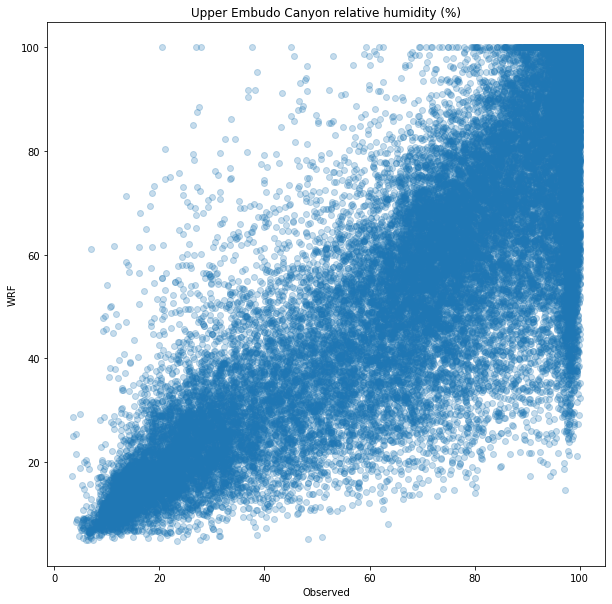

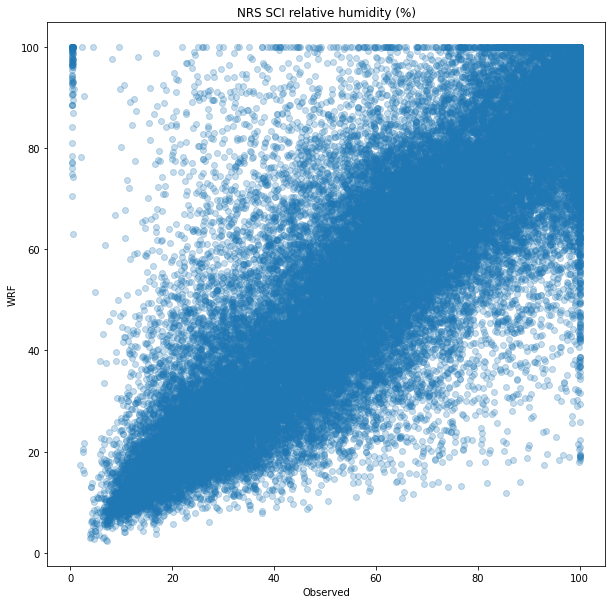

In [11]:
plot_scatter(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_scatter(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_scatter(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')

## CDF Plots

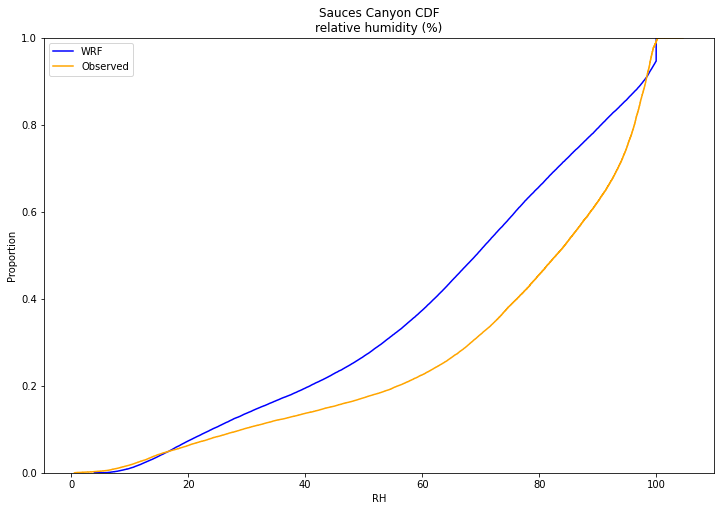

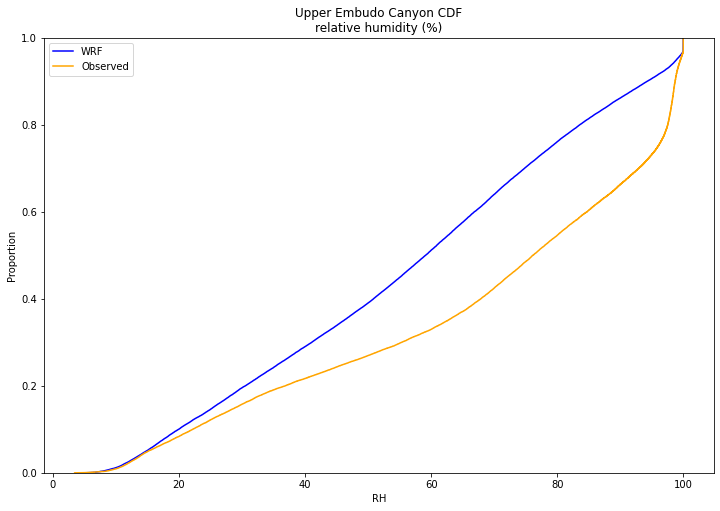

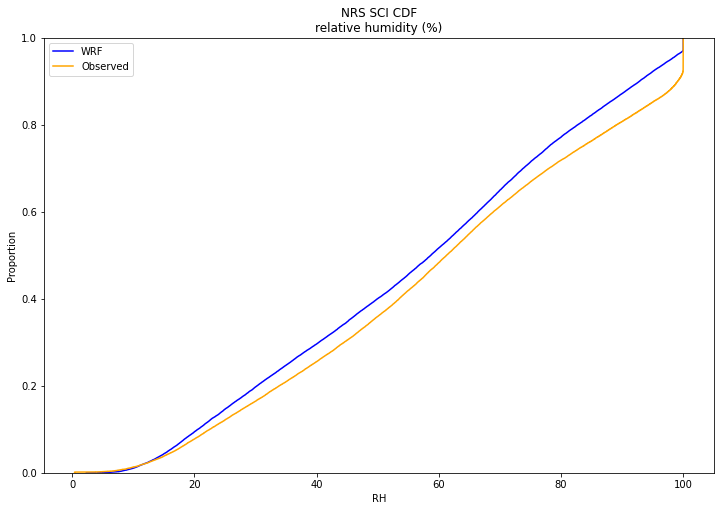

In [12]:
plot_cdf(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_cdf(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_cdf(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')

## PDF Plots

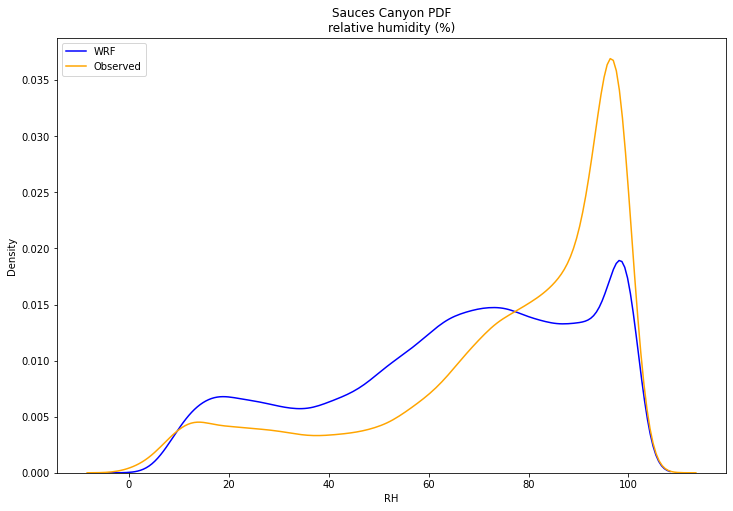

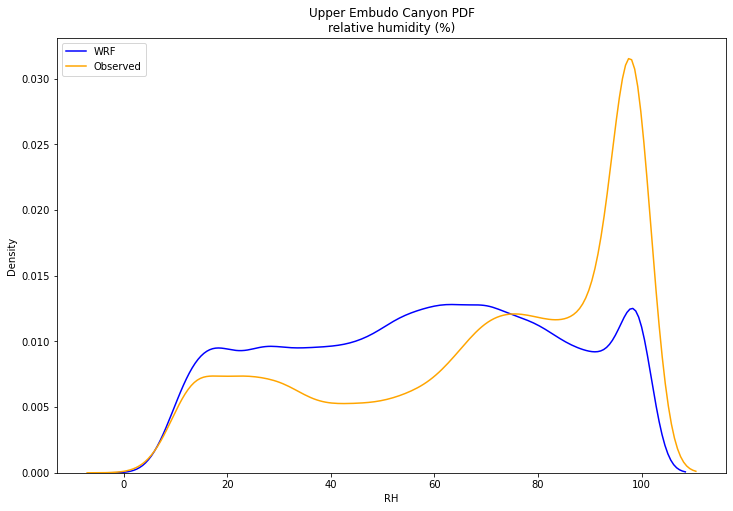

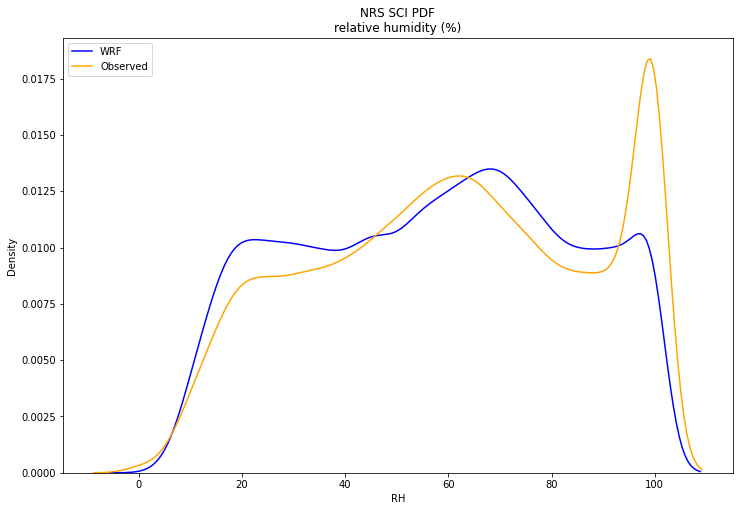

In [13]:
plot_kde(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_kde(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_kde(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')

## Statistics

In [14]:
print(ovar)
print('Sauces Canyon')
run_stats(wsauc, osauc, wvar, ovar)

print('Upper Embudo Canyon')
run_stats(wupem, oupem, wvar, ovar)

print('NRS SCI')
run_stats(wnrs_sci, onrs_sci, wvar, ovar)

relative humidity (%)
Sauces Canyon
Correlation: 0.81
Bias: -9.06
RMSE: 18.14
MAE: 13.28

Upper Embudo Canyon
Correlation: 0.83
Bias: -12.32
RMSE: 20.46
MAE: 15.03

NRS SCI
Correlation: 0.82
Bias: -4.03
RMSE: 16.03
MAE: 11.45



# Air Temperature 

## Time Series Plots

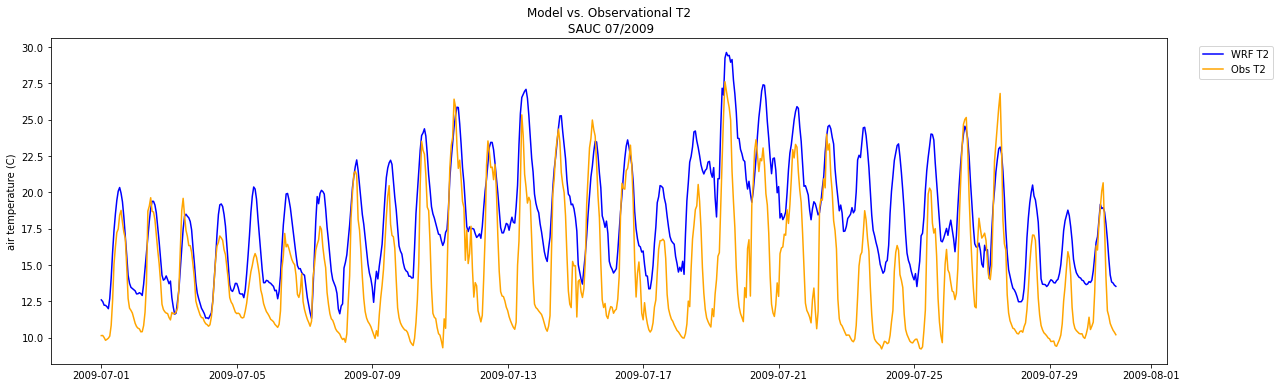

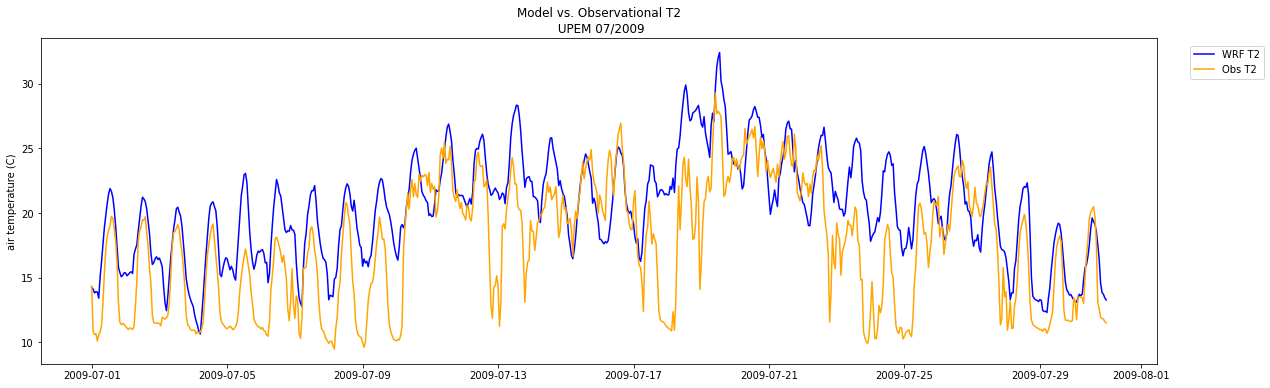

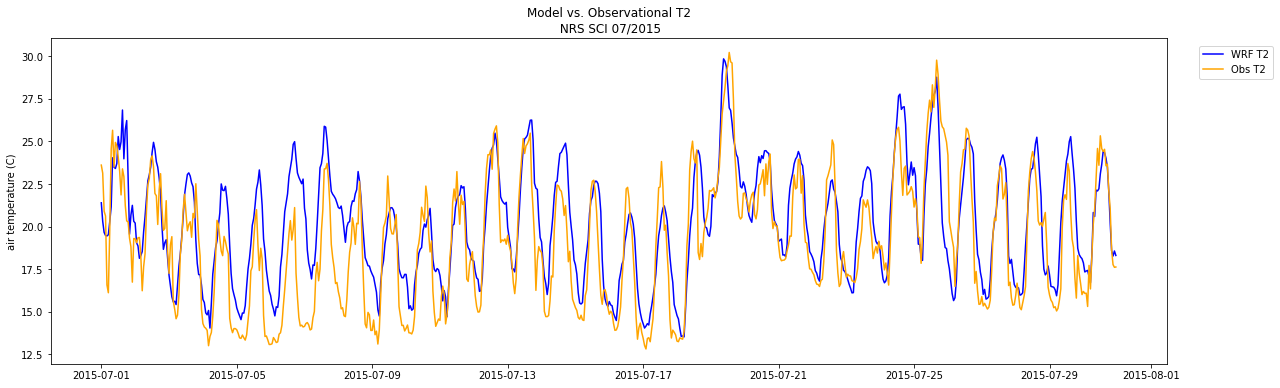

In [15]:
#### July T2 ####
daterange = ['2009-07-01','2009-07-30']
nrs_daterange = ['2015-07-01', '2015-07-30']
wvar = 'T2'
ovar = 'air temperature (C)'
plot_var(wsauc, osauc, wvar, ovar, daterange, 'SAUC')
plot_var(wupem, oupem, wvar, ovar, daterange, 'UPEM')
plot_var(wnrs_sci, onrs_sci, wvar, ovar, nrs_daterange, 'NRS SCI')

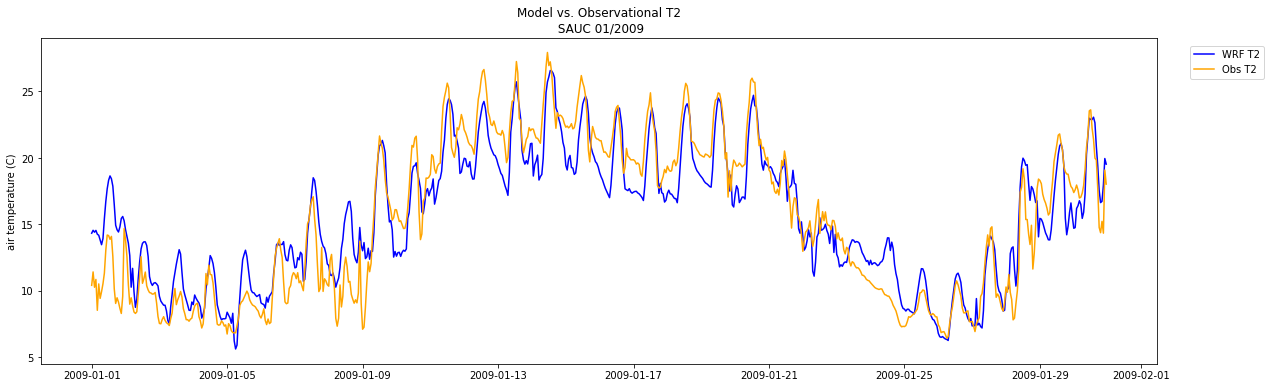

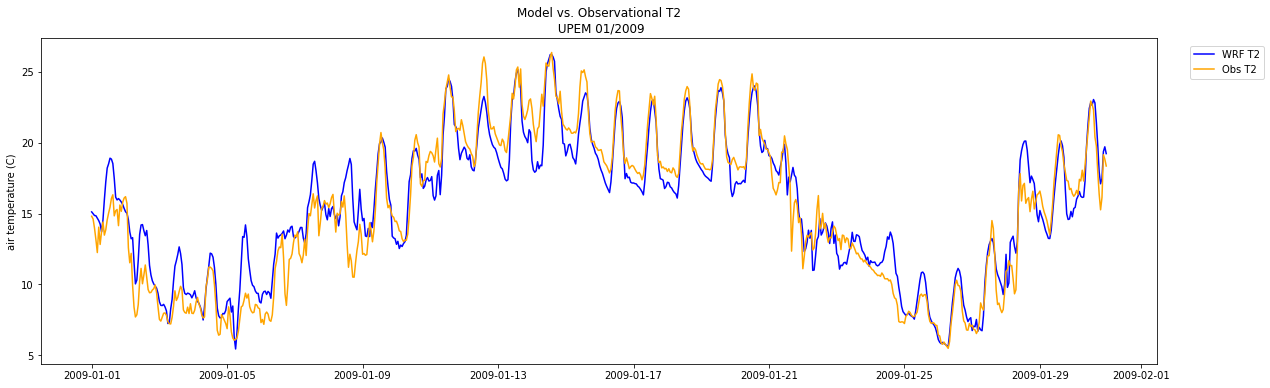

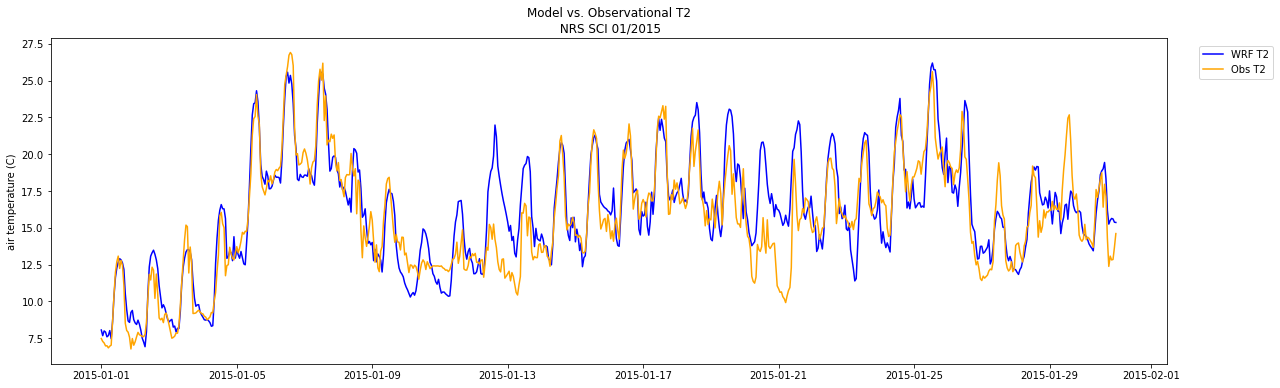

In [16]:
#### January T2 ####
daterange = ['2009-01-01','2009-01-30']
nrs_daterange = ['2015-01-01', '2015-01-30']
wvar = 'T2'
ovar = 'air temperature (C)'
plot_var(wsauc, osauc, wvar, ovar, daterange, 'SAUC')
plot_var(wupem, oupem, wvar, ovar, daterange, 'UPEM')
plot_var(wnrs_sci, onrs_sci, wvar, ovar, nrs_daterange, 'NRS SCI')

## Scatter Plots 

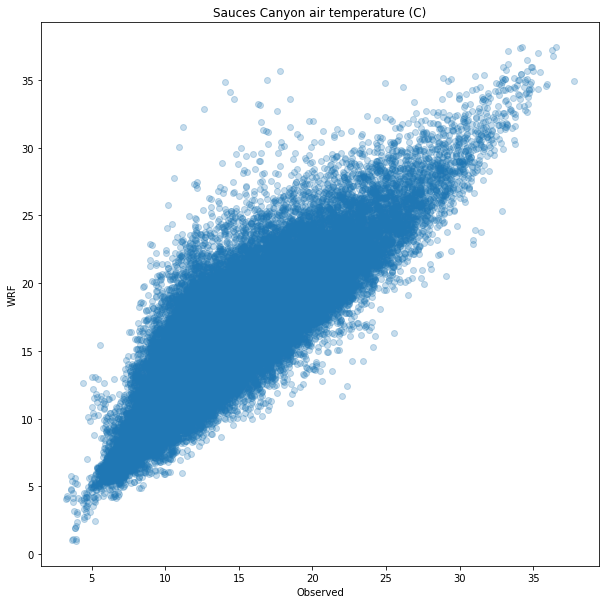

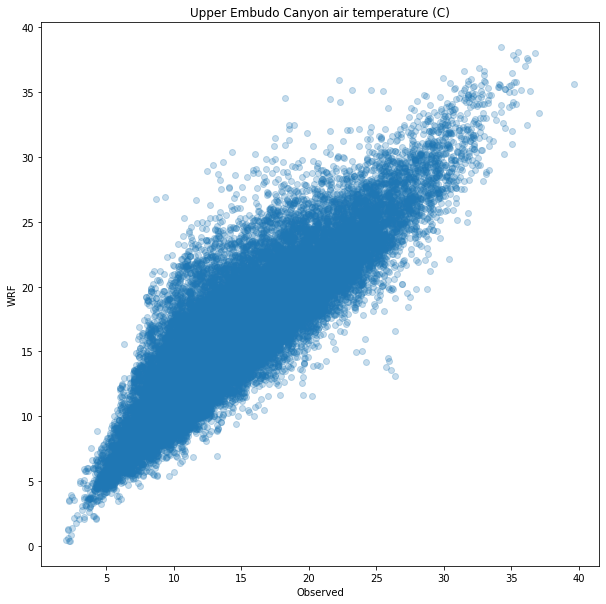

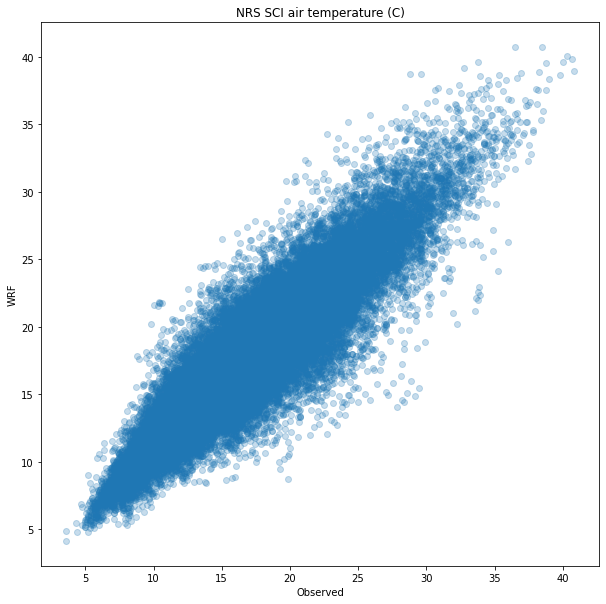

In [17]:
plot_scatter(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_scatter(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_scatter(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')

## CDF Plot

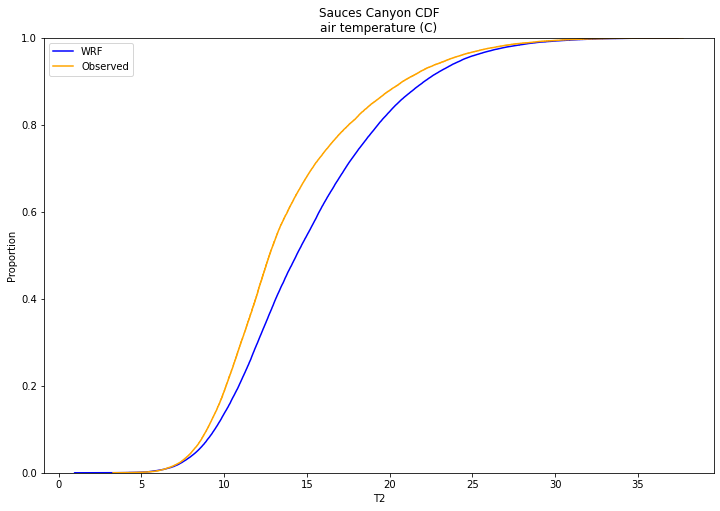

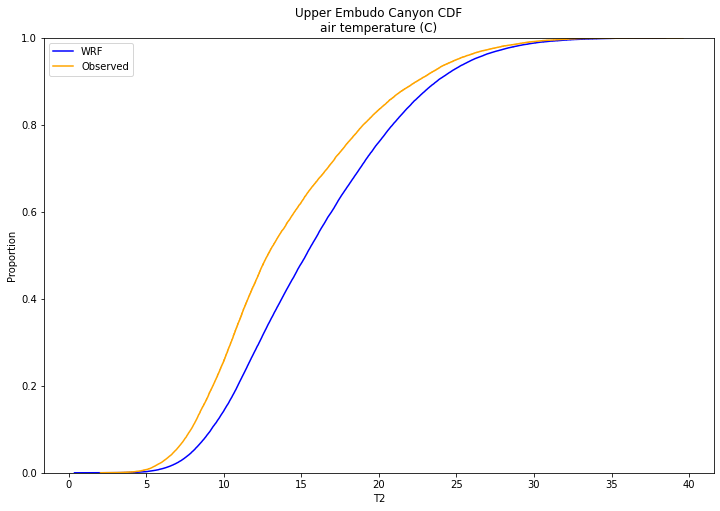

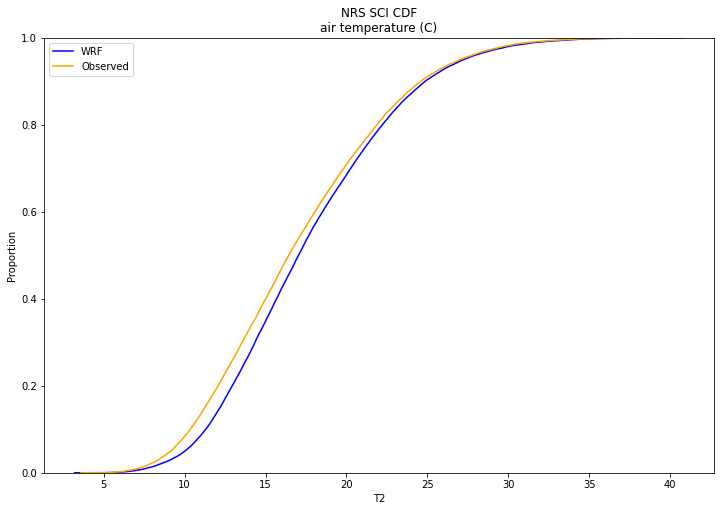

In [18]:
plot_cdf(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_cdf(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_cdf(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')


## PDF Plots

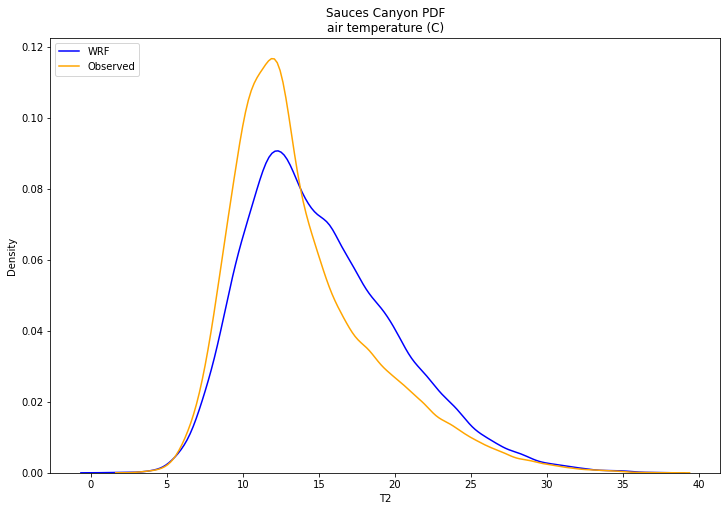

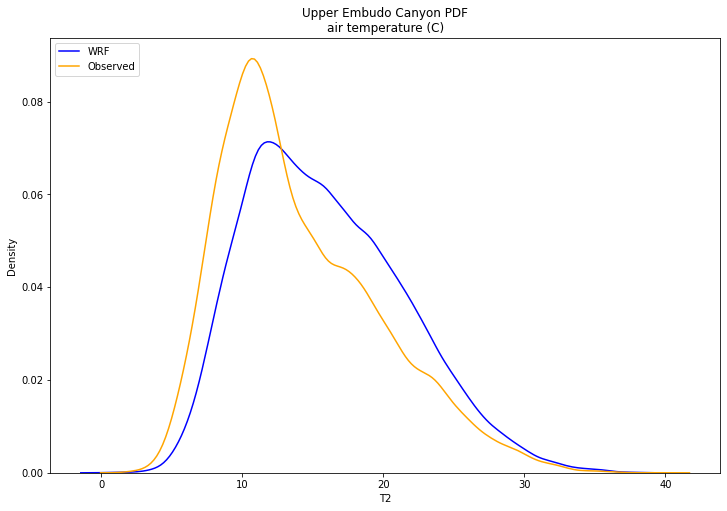

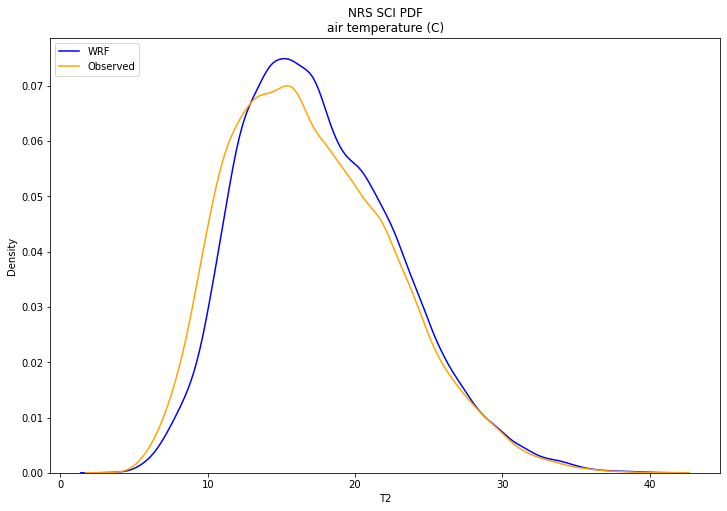

In [19]:
plot_kde(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_kde(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_kde(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')

## Statistics 

In [20]:
print(ovar)
print(f'Sauces Canyon')
run_stats(wsauc, osauc, wvar, ovar)

print(f'Upper Embudo Canyon')
run_stats(wupem, oupem, wvar, ovar)

print('NRS SCI')
run_stats(wnrs_sci, onrs_sci, wvar, ovar)

air temperature (C)
Sauces Canyon
Correlation: 0.87
Bias: 1.36
RMSE: 2.88
MAE: 2.11

Upper Embudo Canyon
Correlation: 0.89
Bias: 1.55
RMSE: 3.06
MAE: 2.23

NRS SCI
Correlation: 0.91
Bias: 0.67
RMSE: 2.39
MAE: 1.84



# Wind Speed

In [21]:
wvar = 'WND_SPD'
ovar = 'wind speed (m/s)'

## Time Series Plots

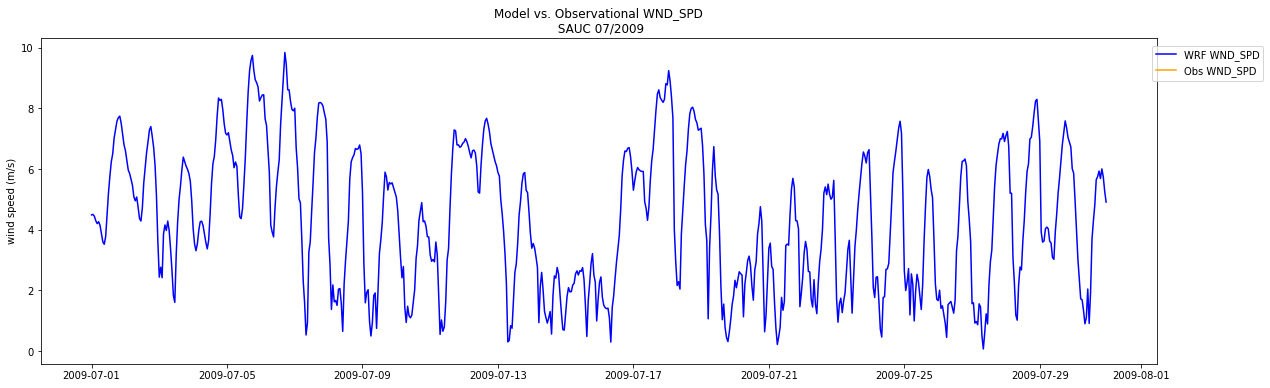

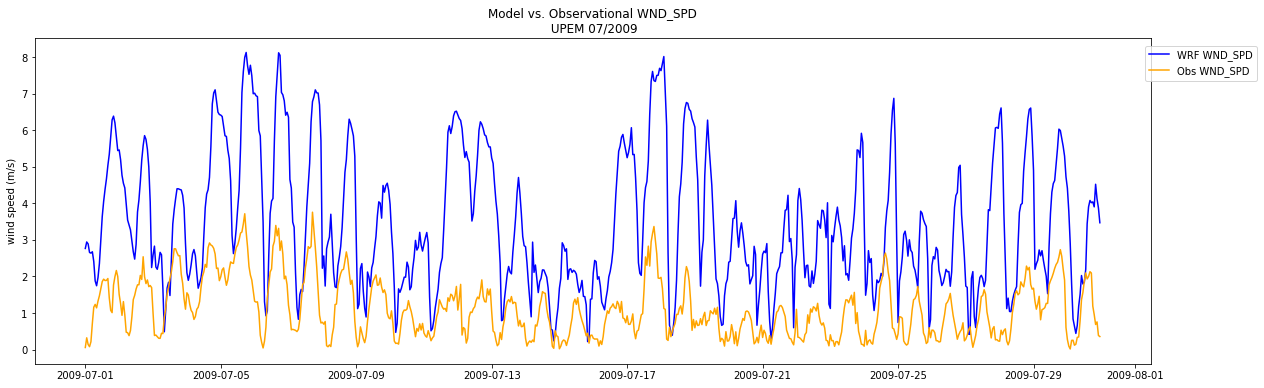

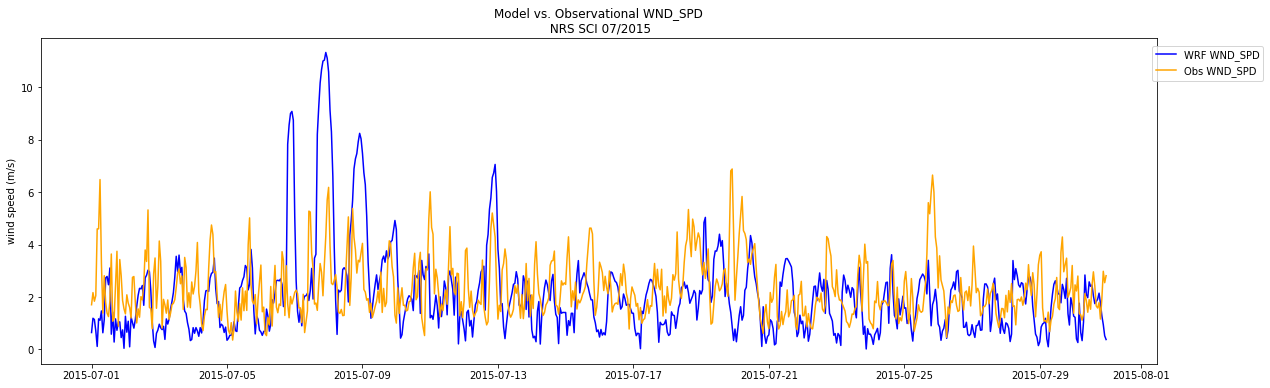

In [22]:
#### July T2 ####
daterange = ['2009-07-01','2009-07-30']
nrs_daterange = ['2015-07-01', '2015-07-30']
plot_var(wsauc, osauc, wvar, ovar, daterange, 'SAUC')
plot_var(wupem, oupem, wvar, ovar, daterange, 'UPEM')
plot_var(wnrs_sci, onrs_sci, wvar, ovar, nrs_daterange, 'NRS SCI')

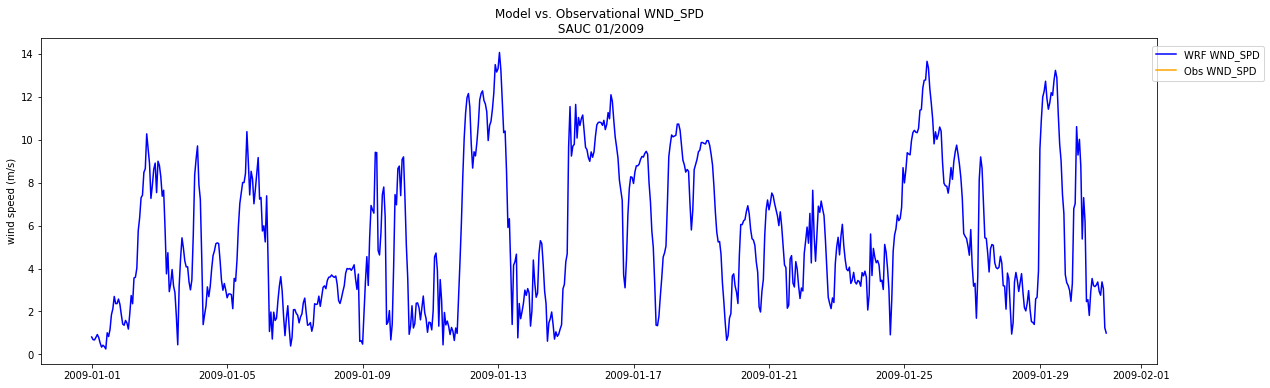

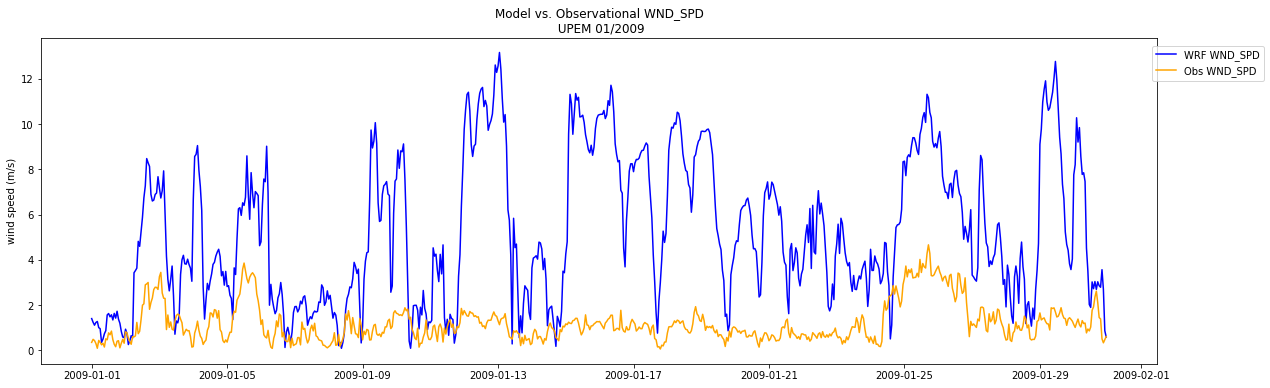

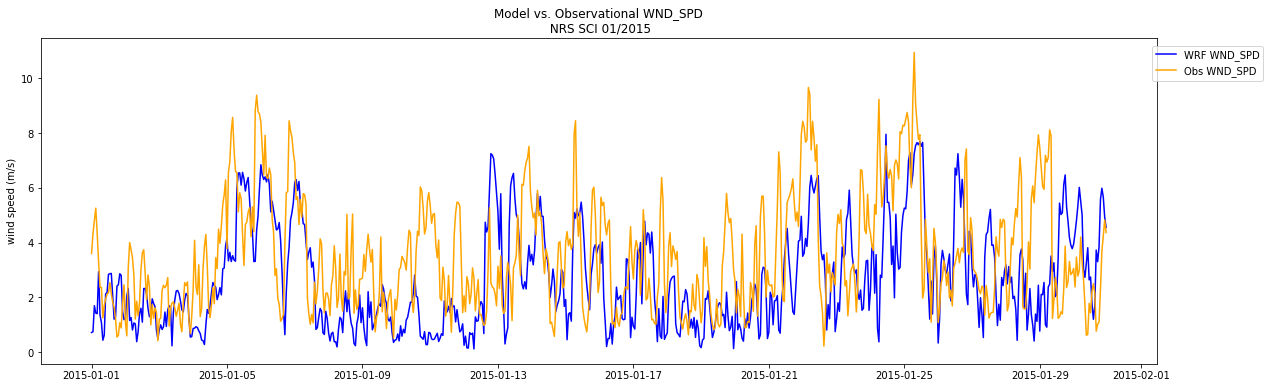

In [23]:
#### January T2 ####
daterange = ['2009-01-01','2009-01-30']
nrs_daterange = ['2015-01-01', '2015-01-30']
plot_var(wsauc, osauc, wvar, ovar, daterange, 'SAUC')
plot_var(wupem, oupem, wvar, ovar, daterange, 'UPEM')
plot_var(wnrs_sci, onrs_sci, wvar, ovar, nrs_daterange, 'NRS SCI')

## Scatter Plots 

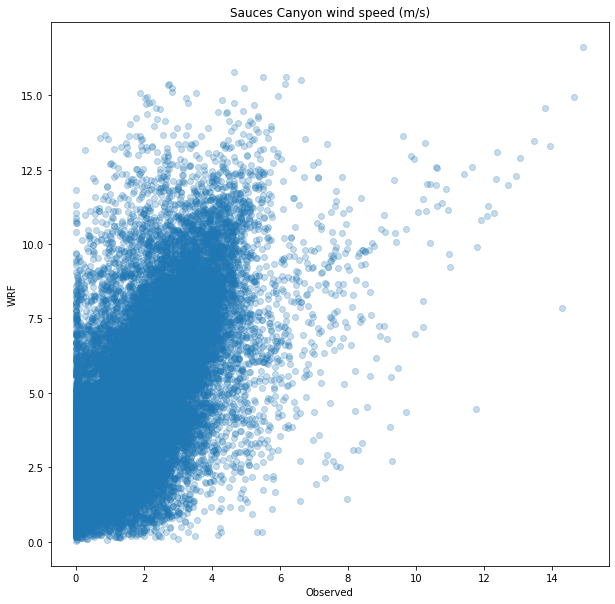

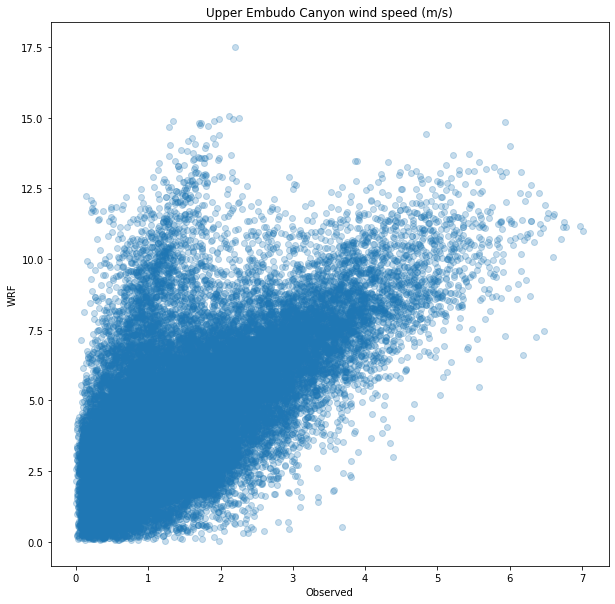

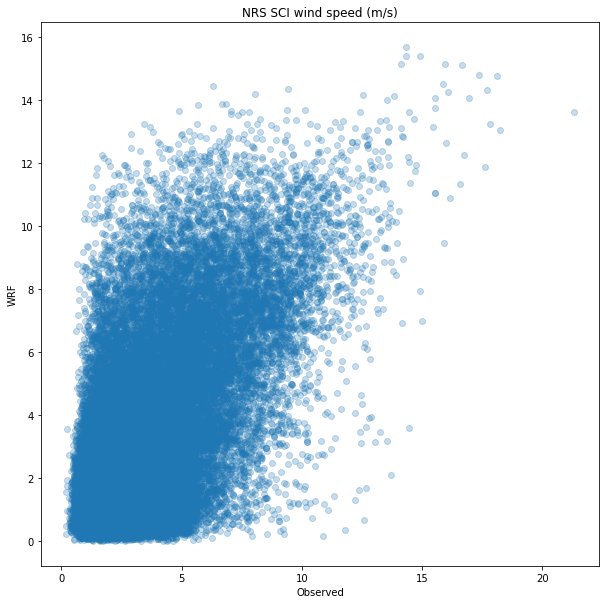

In [24]:
plot_scatter(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_scatter(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_scatter(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')

## CDF Plot

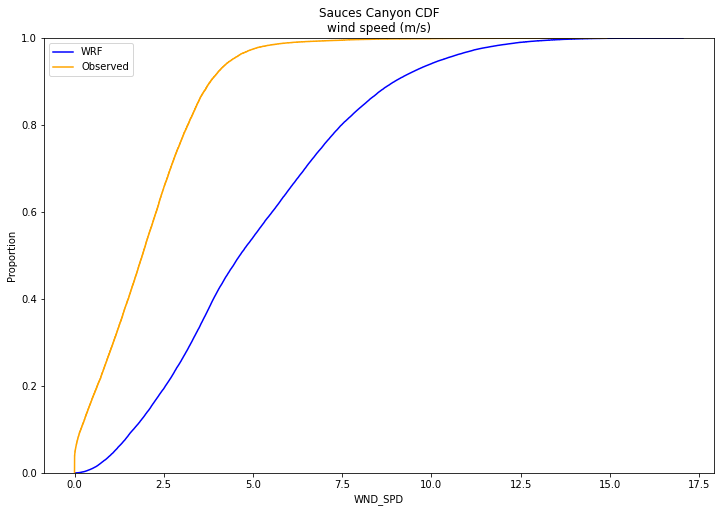

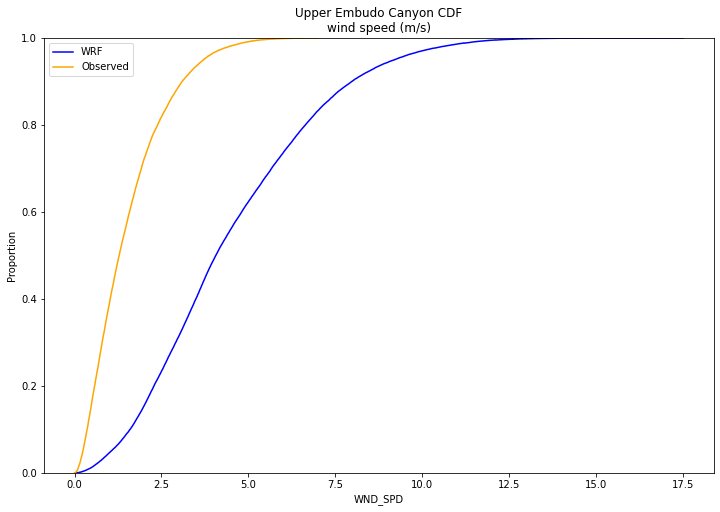

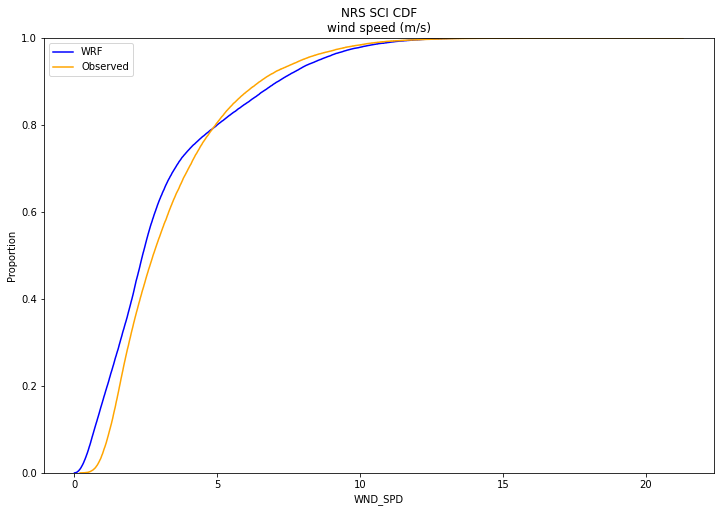

In [25]:
plot_cdf(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_cdf(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_cdf(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')


## PDF Plots

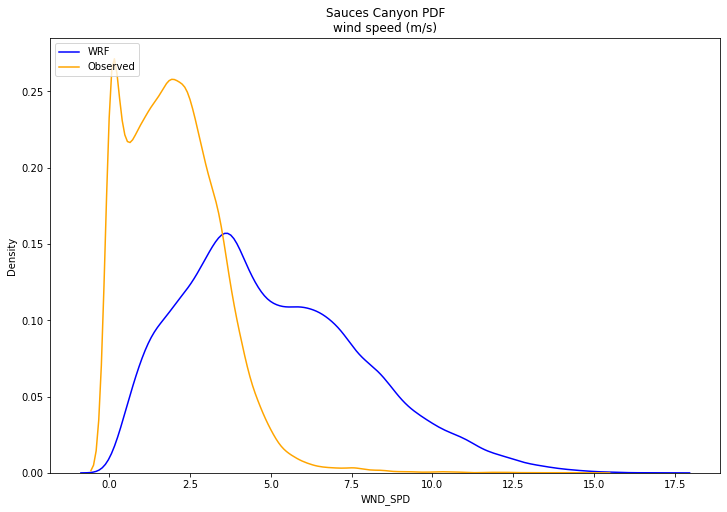

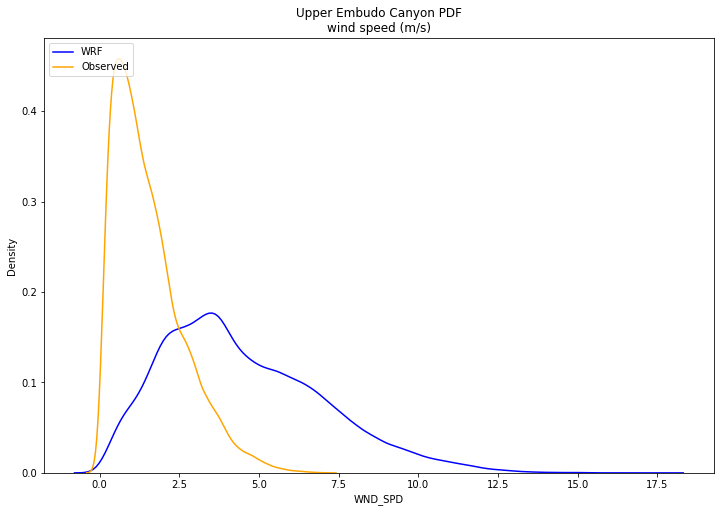

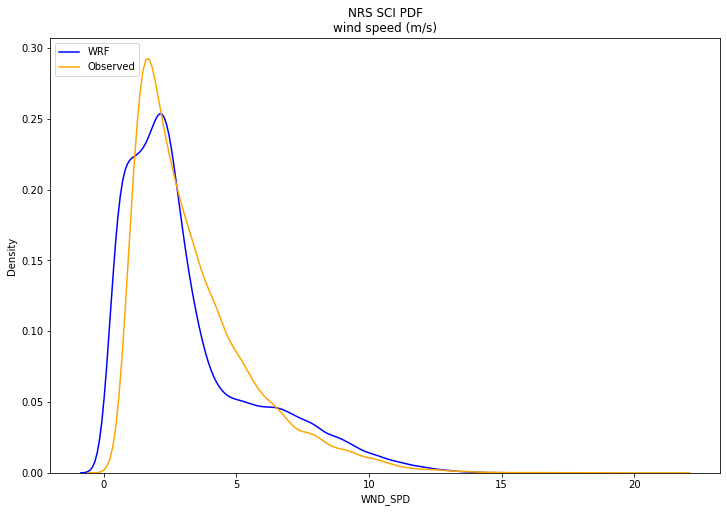

In [26]:
plot_kde(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_kde(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_kde(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')

## Statistics 

In [27]:
print(ovar)
print(f'Sauces Canyon')
run_stats(wsauc, osauc, wvar, ovar)

print(f'Upper Embudo Canyon')
run_stats(wupem, oupem, wvar, ovar)

print('NRS SCI')
run_stats(wnrs_sci, onrs_sci, wvar, ovar)

wind speed (m/s)
Sauces Canyon
Correlation: 0.59
Bias: 3.0
RMSE: 3.72
MAE: 3.11

Upper Embudo Canyon
Correlation: 0.63
Bias: 3.03
RMSE: 3.66
MAE: 3.05

NRS SCI
Correlation: 0.6
Bias: -0.18
RMSE: 2.18
MAE: 1.65



# Wind Direction

In [28]:
wvar = 'WND_DIR'
ovar = 'wind direction (deg)'

## Time Series Plots

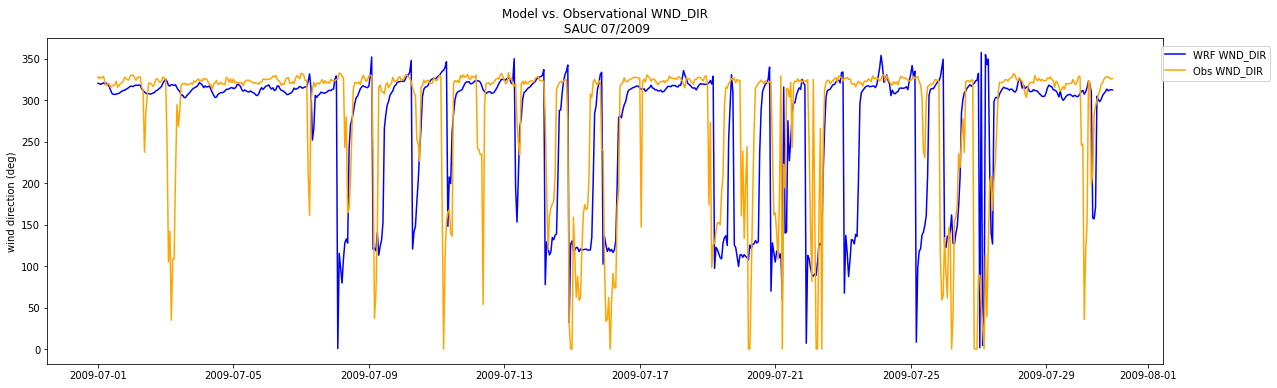

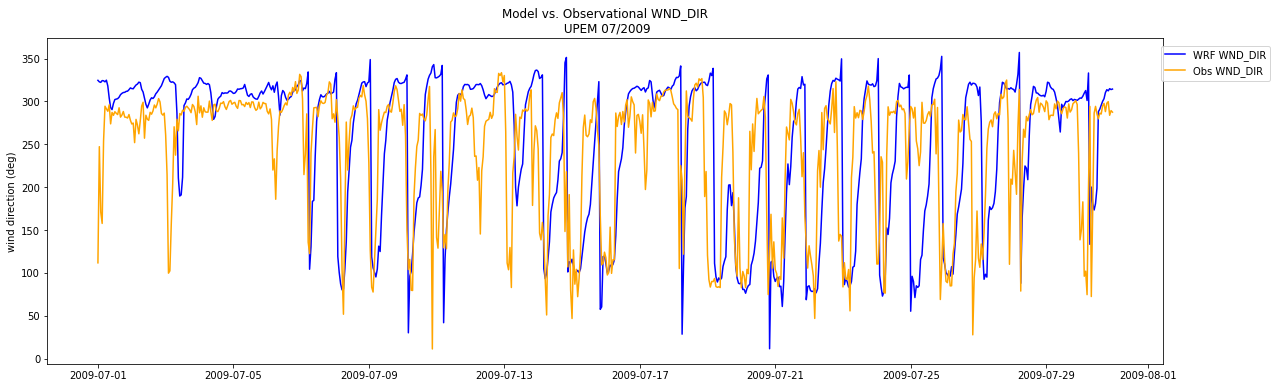

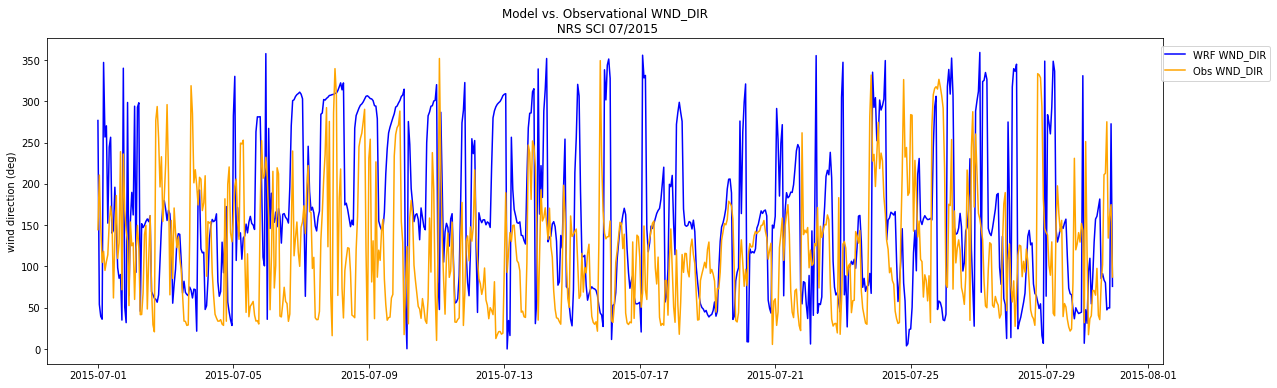

In [29]:
#### July T2 ####
daterange = ['2009-07-01','2009-07-30']
nrs_daterange = ['2015-07-01', '2015-07-30']
plot_var(wsauc, osauc, wvar, ovar, daterange, 'SAUC')
plot_var(wupem, oupem, wvar, ovar, daterange, 'UPEM')
plot_var(wnrs_sci, onrs_sci, wvar, ovar, nrs_daterange, 'NRS SCI')

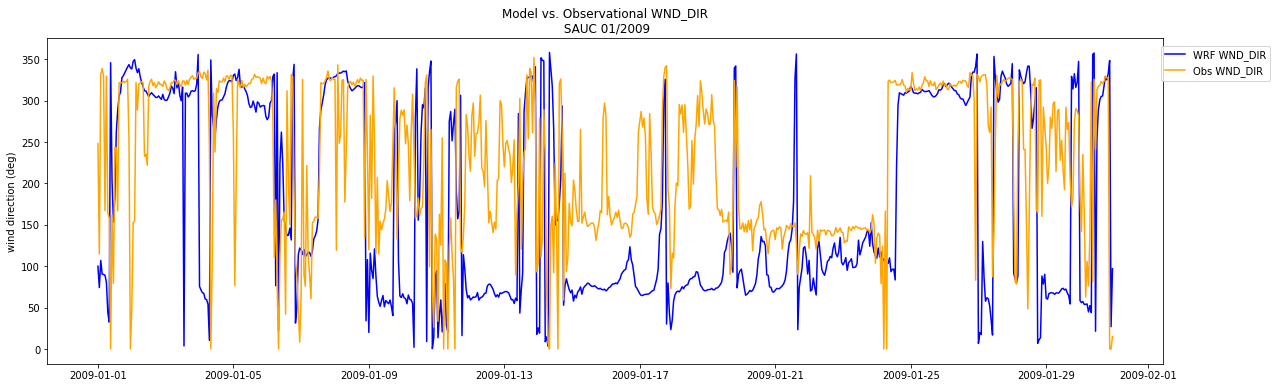

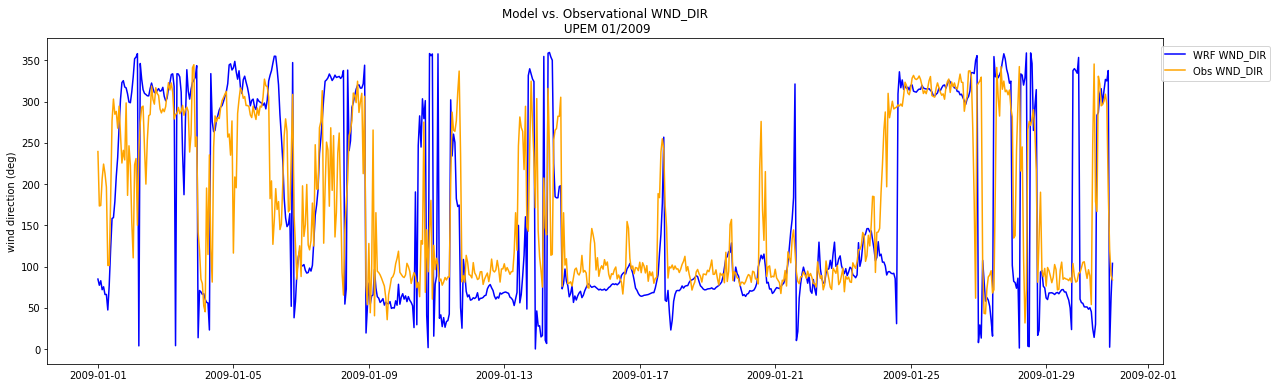

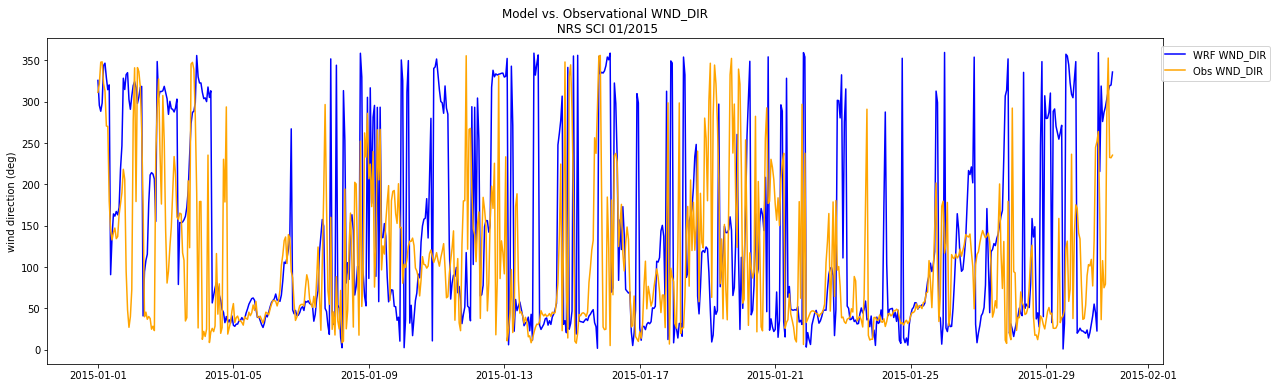

In [30]:
#### January T2 ####
daterange = ['2009-01-01','2009-01-30']
nrs_daterange = ['2015-01-01', '2015-01-30']
plot_var(wsauc, osauc, wvar, ovar, daterange, 'SAUC')
plot_var(wupem, oupem, wvar, ovar, daterange, 'UPEM')
plot_var(wnrs_sci, onrs_sci, wvar, ovar, nrs_daterange, 'NRS SCI')

## Scatter Plots 

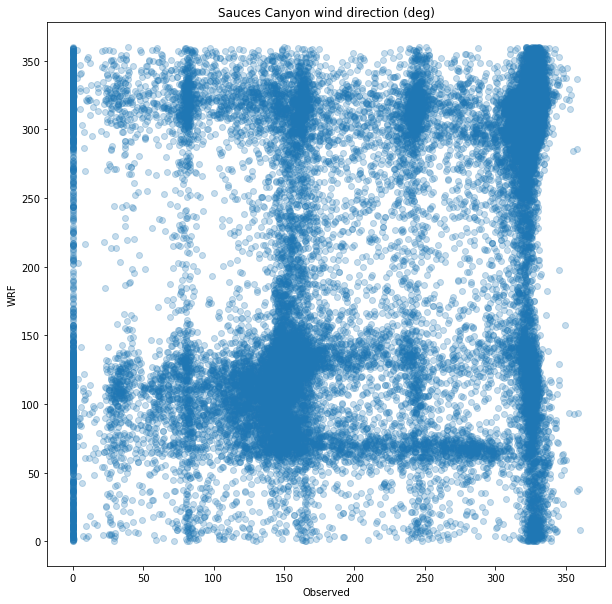

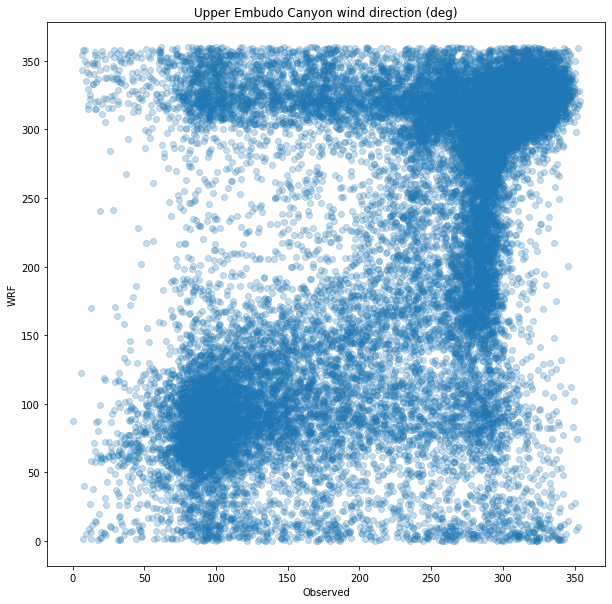

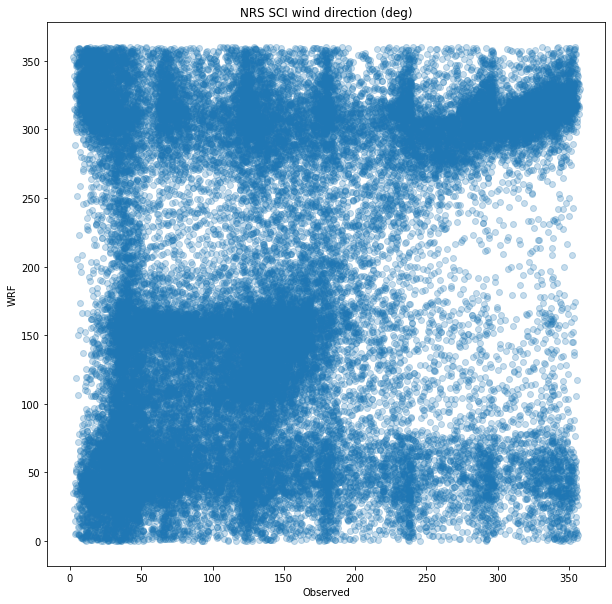

In [31]:
plot_scatter(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_scatter(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_scatter(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')

## CDF Plot

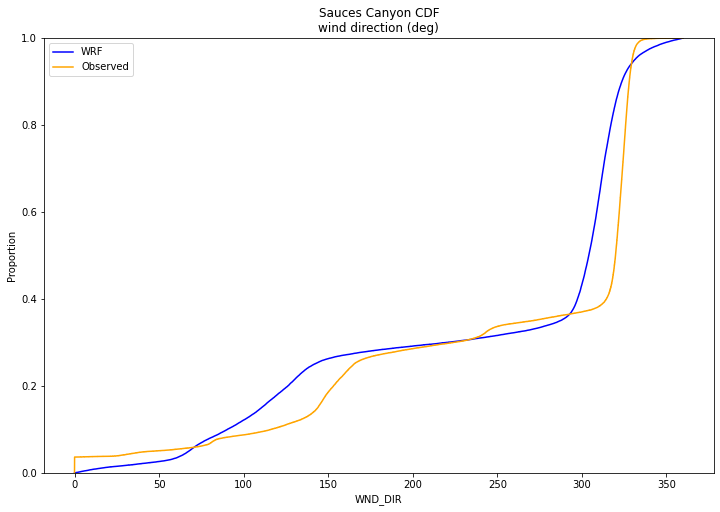

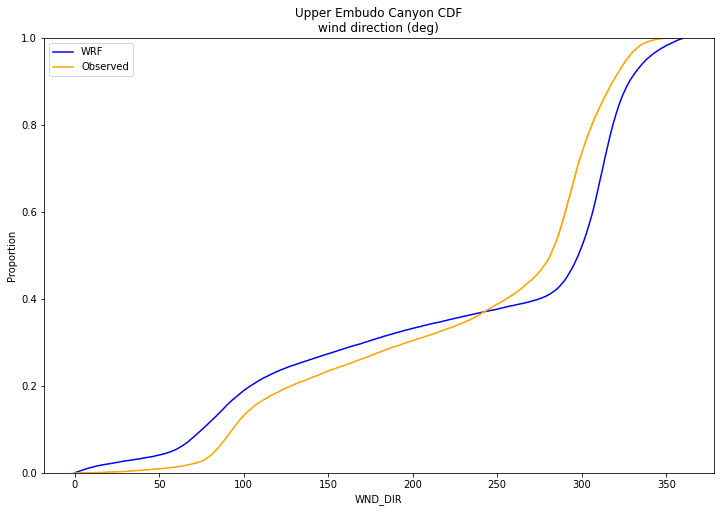

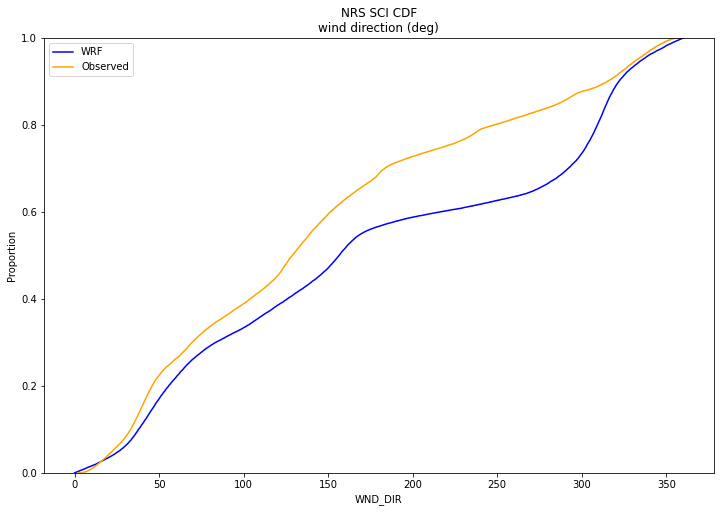

In [32]:
plot_cdf(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_cdf(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_cdf(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')


## PDF Plots

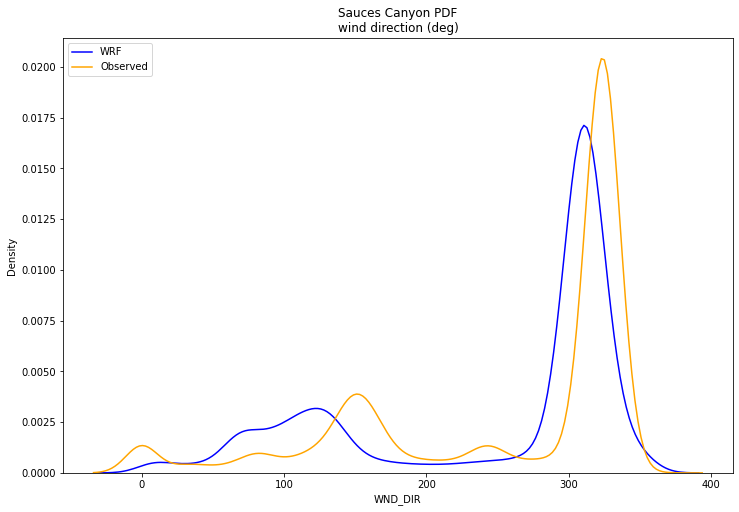

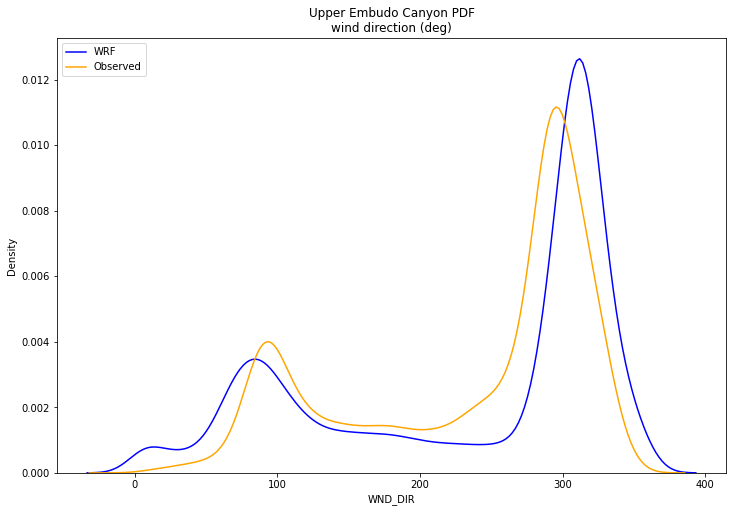

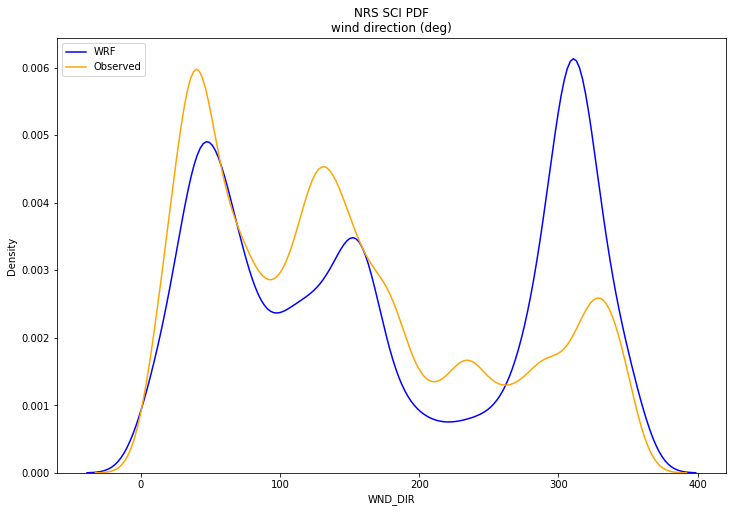

In [33]:
plot_kde(wsauc, osauc, wvar, ovar, 'Sauces Canyon')
plot_kde(wupem, oupem, wvar, ovar, 'Upper Embudo Canyon')
plot_kde(wnrs_sci, onrs_sci, wvar, ovar, 'NRS SCI')

## Statistics 

In [34]:
print(ovar)
print(f'Sauces Canyon')
run_stats(wsauc, osauc, wvar, ovar)

print(f'Upper Embudo Canyon')
run_stats(wupem, oupem, wvar, ovar)

print('NRS SCI')
run_stats(wnrs_sci, onrs_sci, wvar, ovar)

wind direction (deg)
Sauces Canyon
Correlation: 0.54
Bias: -9.33
RMSE: 93.32
MAE: 55.06

Upper Embudo Canyon
Correlation: 0.63
Bias: -1.76
RMSE: 84.09
MAE: 52.35

NRS SCI
Correlation: 0.32
Bias: 33.85
RMSE: 129.92
MAE: 92.61

